## SEC Filing Sentiment Analysis Report 

## Overview

This report analyzes the relationship between linguistic sentiment variables extracted from SEC filings and subsequent stock price movements. Key findings:
 - Sector-specific patterns in sentiment/return correlations
 - Differential market reactions in short-term (0-2 day) vs medium-term (3-10 day) returns
 - Operational litigation language shows strong sector concentration
 - Litigious uncertainty correlates with post-event volatility

### Variables of Interest
| Variable Name                       | Description                                                                                              | Sentiment/Context                         |
|-------------------------------------|----------------------------------------------------------------------------------------------------------|-------------------------------------------|
| intensifiers_ML_positive_unigram    | A list of positive unigrams that intensify positive sentiment ("extremely", "incredibly").          | Positive, intensification                  |
| intensifiers_ML_negative_unigram    | A list of negative unigrams that intensify negative sentiment (e.g., "deeply", "severely").               | Negative, intensification                  |
| negators_LM_positive                | Words that reverse or negate positive sentiment in the LM (legal/linguistic) lexicon.             | Positive negation                         |
| negators_LM_negative                | Words that reverse or negate negative sentiment in the LM lexicon.                                       | Negative negation                         |
| mitigators_LM_litigious             | Terms that soften or reduce the impact of litigious language within the LM framework.                     | Litigious sentiment mitigation             |
| maximizers_LM_positive              | Words that amplify or maximize positive sentiment in the LM lexicon.                                     | Positive amplification                     |
| operational_LM_litigious            | Terms reflecting litigious language specifically related to operational contexts in the LM dictionary.   | Litigious/operational                      |
| macro_LM_litigious                  | A macroeconomic set of words associated with litigious sentiments in the LM lexicon.               | Litigious (macro perspective)              |
| competition_LM_litigious            | Words capturing litigious language in competitive contexts as defined by the LM lexicon.                 | Litigious in competitive settings          |
| competition_LM_negative             | Negative sentiment words specific to competitive scenarios from the LM lexicon.                          | Negative (competition-specific)            |
| uncertainty_LM_negative             | Words indicating uncertainty that carry a negative sentiment in the LM lexicon.                          | Negative uncertainty                       |
| uncertainty_LM_litigious            | Terms denoting uncertainty within a litigious context from the LM dictionary.                          | Litigious uncertainty                      |
| ML_positive_unigram                 | A list of positive sentiment unigrams derived from ML_positive_unigram lexicon.                  | Positive (ML-based)                        |
| ML_negative_unigram                 | A list of negative sentiment unigrams derived from ML_negative_unigram lexicon.                                  | Negative (ML-based)                        |
| LM_positive                         | A collection of positive sentiment words from the LM lexicon (likely more comprehensive than unigrams).    | Positive                                   |
| LM_negative                         | A collection of negative sentiment words from the LM lexicon.                                          | Negative                                   |
| LM_litigious                        | A set of words related to litigious or legal-sounding sentiment from the LM lexicon.                      | Litigious                                  |


### Loading in the outputs (complete_df, returns, firm_day_event)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sentiment_df_complete = pd.read_csv('output/complete_df.csv')
firm_day_event = pd.read_csv('output/firm_day_event.csv')
returns_df = pd.read_csv('output/returns.csv')
unique_triples = firm_day_event[['ticker', 'r_0_2', 'r_3_10']].drop_duplicates()
merged_df = pd.merge(sentiment_df_complete, unique_triples, left_on = 'Symbol', right_on='ticker', how='left', validate='1:1').drop(columns = ['Unnamed: 0','ticker'])

### Visualization 1: Correlation Heatmap of sentiment variables and r_0_2 / r_3_10

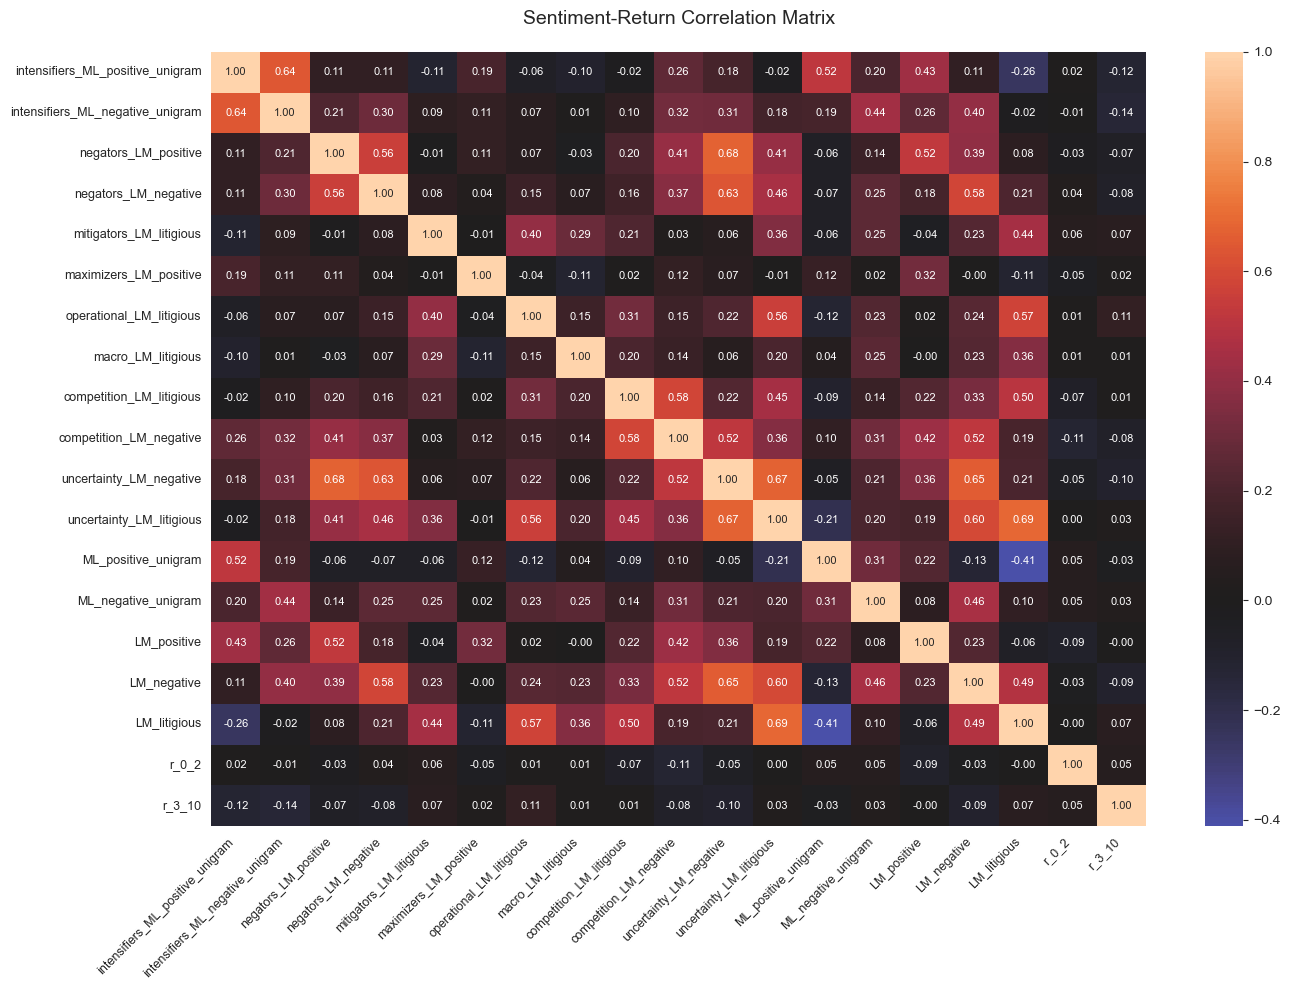

In [20]:
def plot_enhanced_heatmap(matrix, title):
    plt.figure(figsize=(14, 10))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='icefire',
                center=0, annot_kws={'size':8})
    plt.title(title, fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    
corr_matrix = merged_df.loc[:,'intensifiers_ML_positive_unigram':'r_3_10'].corr()
plot_enhanced_heatmap(corr_matrix, 'Sentiment-Return Correlation Matrix')
plt.show()


 1. Sector-agnostic correlations show limited direct relationships
 2. Strong inter-correlation between litigation-related variables
 3. Limited correlation between immediate and lagged market reactions


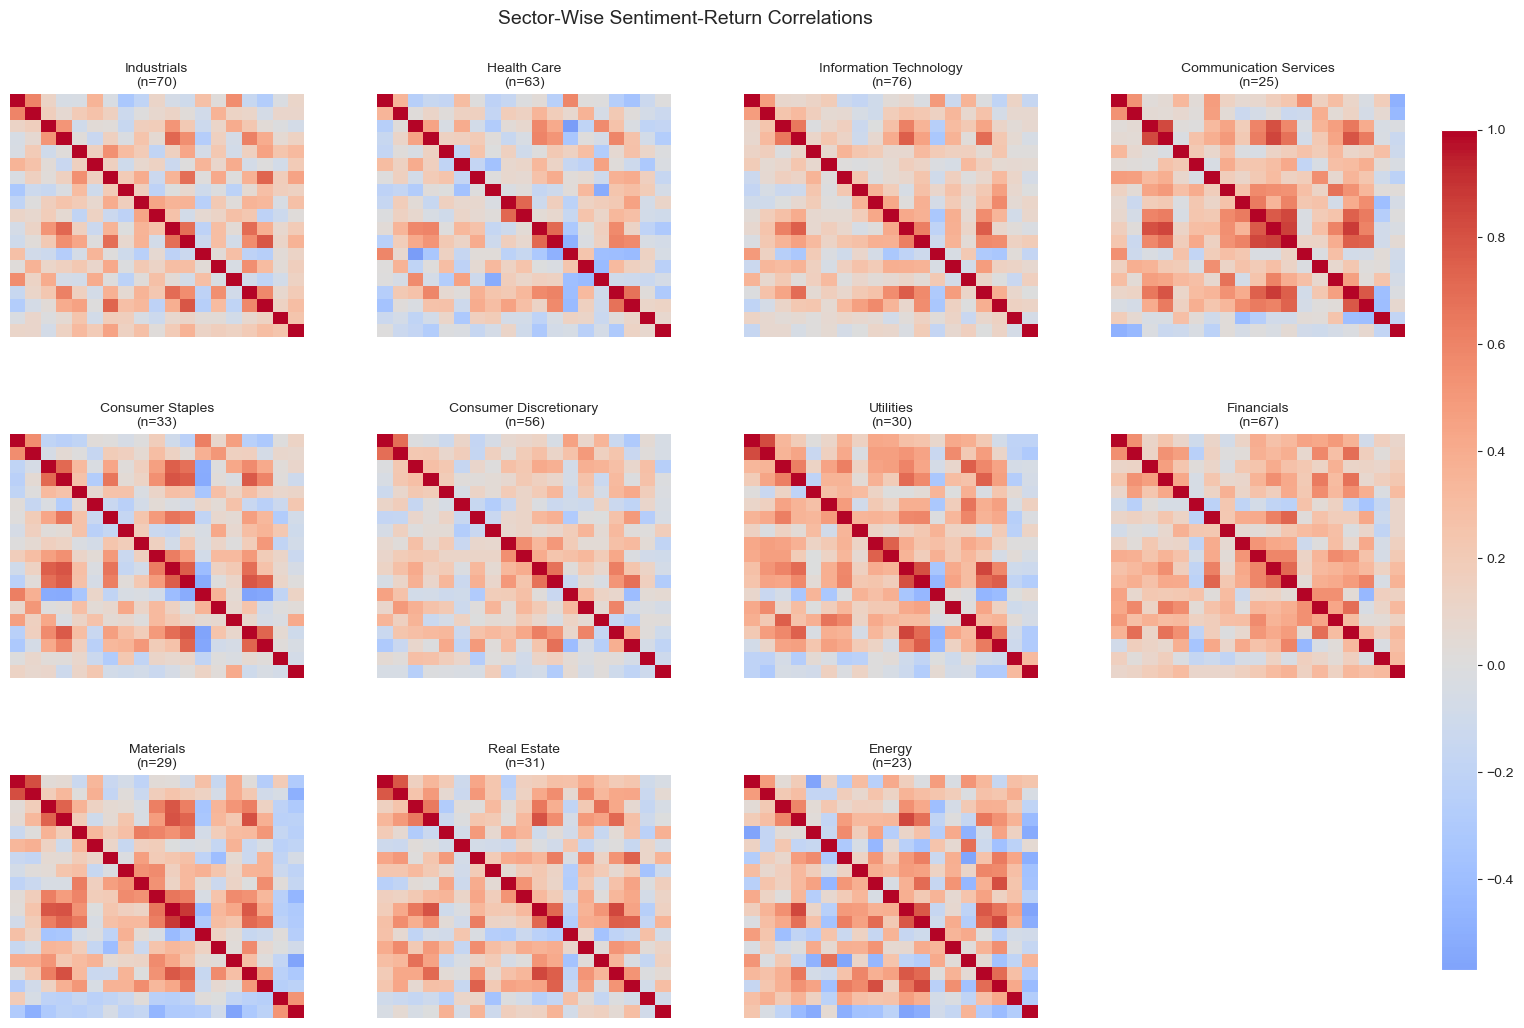

In [21]:
sectors = merged_df['GICS Sector'].unique()
n_cols = 4
n_rows = int(np.ceil(len(sectors)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.25, hspace=0.4)

for idx, sector in enumerate(sectors):
    ax = axes.flatten()[idx]
    sector_data = merged_df[merged_df['GICS Sector'] == sector]
    sector_corr = sector_data.loc[:, 'intensifiers_ML_positive_unigram':'r_3_10'].corr()
    
    sns.heatmap(sector_corr, ax=ax, cmap='coolwarm', center=0,
                cbar=False, annot=False,  # Modified: removed annotations
                xticklabels=False, yticklabels=False)
    ax.set_title(f'{sector}\n(n={len(sector_data)})', fontsize=10)
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)

for idx in range(len(sectors), n_rows*n_cols):
    fig.delaxes(axes.flatten()[idx])

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ax.collections[0], cax=cax)
plt.suptitle('Sector-Wise Sentiment-Return Correlations', y=0.95, fontsize=14)
plt.show()

* Here, we see that the variables tend to vary in correlation accross sector. Many sentiment measures like intensifiers, negators, and litigious terms tend to correlate strongly with one another within a given industry. However, the _magnitude_ and sometimes the _sign_ of these correlations vary from one industry to another, suggesting that the underlying language or emphasis in filings differs by industry.
* Financials show strongest litigation language correlations, while sectors like Industrials have show the strongest operational language correlations.
* There are also differences in correlations between `r_0_2` and `r_3_10`, indicating that immediate post-filing returns and slightly-delayed returns are shaped by different market reactions, given a sector. While these correlations tend to be weaker, this might be due to the averages in correlations. For example, if a company releases positive news in their 10-K, the market might increase buying pressure and overall returns, whereas the opposite would occur in the event of bad news.




### Contextualizing Returns by Select Variables

In [23]:
def plot_top_company_cum_returns(returns_df, merged_df, sentiment_col, n_top=10):  # Added returns_df parameter
    top_tickers = merged_df.nlargest(n_top, sentiment_col)['Symbol'].unique()
    returns_df['Date'] = pd.to_datetime(returns_df['Date'])
    top_rets = returns_df[top_tickers]
    
    cumulative_returns = top_rets.apply(lambda x: np.exp(x.cumsum()) - 1)
    
    plt.figure(figsize=(10, 6))
    for ticker in cumulative_returns.columns:
        plt.plot(returns_df['Date'], cumulative_returns[ticker], label=ticker)
    
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(f"Cumulative Returns for Top Companies by {sentiment_col}")
    plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



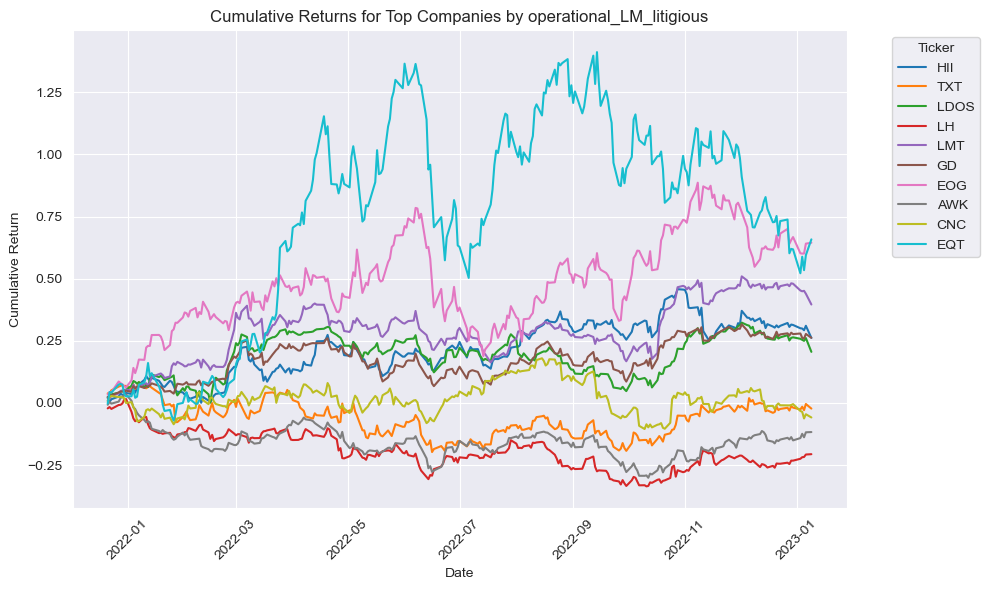

In [29]:
plot_top_company_cum_returns(returns_df, merged_df, 'operational_LM_litigious', n_top=10)

* Here we see that the annual cumulative return for these companies follows a similar trend due to the majority of the highest ranking companies by operation/litigious language are in the Industrials sector.

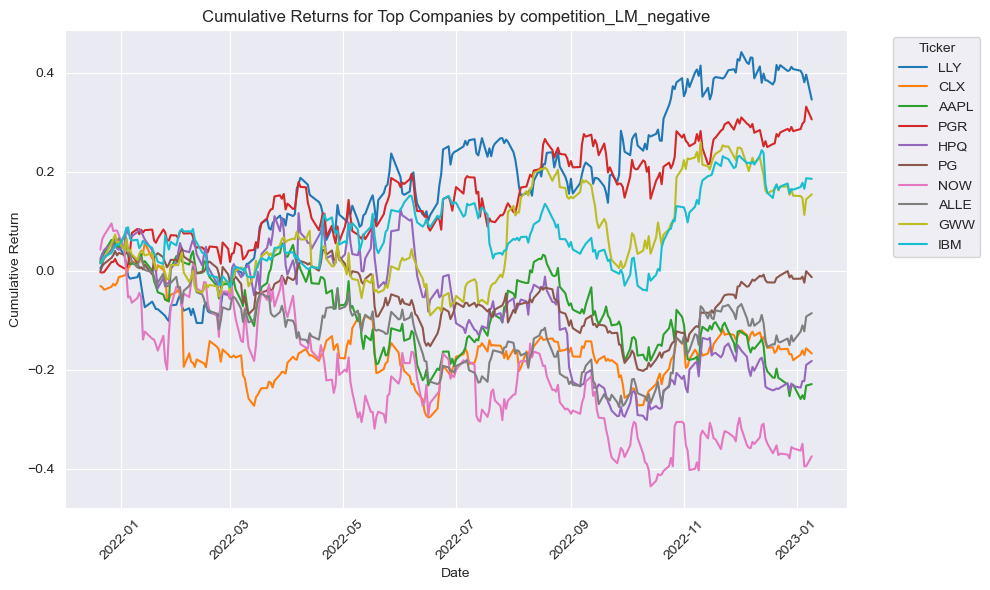

In [28]:
plot_top_company_cum_returns(returns_df, merged_df,'competition_LM_negative', n_top=10)

* There is a roughly normal spread on companies ranked by negative language surrounding their competition; there isn't much of an industry skew here. However, given that the majority of these companies filed around February-March, we observe a downtrend around that time in this basket.

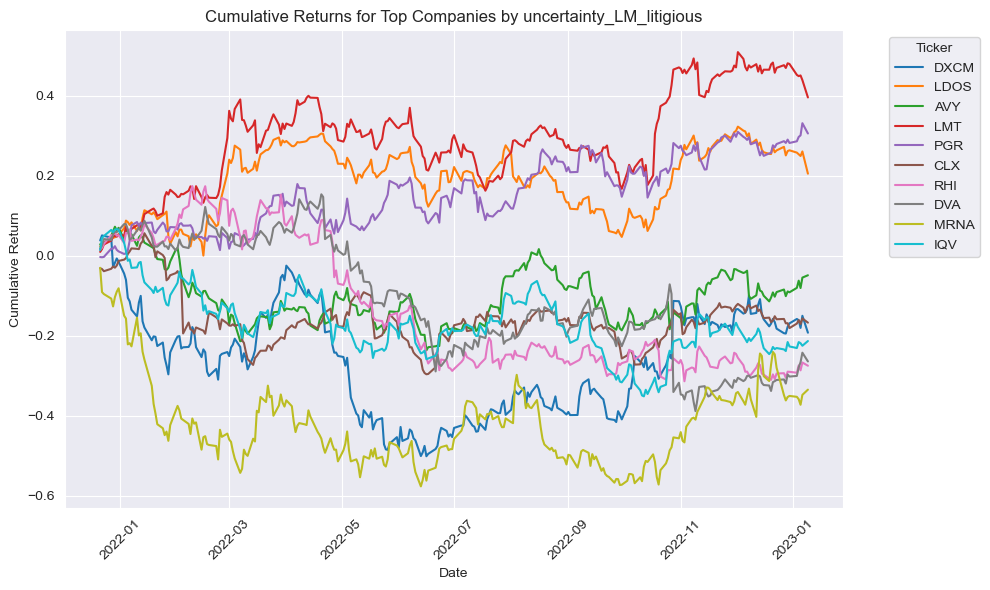

In [27]:
plot_top_company_cum_returns(returns_df, merged_df, 'uncertainty_LM_litigious', n_top=10)

* Around the filing date interval, in which the majority of these companies hover around February-March, we see that their price movements are relatively tight, indicating that the market may have a tendency to over-react to legal ambiguity

In [42]:
sentiment_vars = [
    'intensifiers_ML_negative_unigram',
    'negators_LM_positive',
    'negators_LM_negative',
    'mitigators_LM_litigious',
    'operational_LM_litigious',
    'macro_LM_litigious',
    'competition_LM_litigious',
    'competition_LM_negative',
    'uncertainty_LM_negative',
    'uncertainty_LM_litigious',
]

merged_df['composite_score'] = merged_df[sentiment_vars].sum(axis=1)

mean_score = merged_df['composite_score'].mean()
merged_df['z_score'] = (merged_df['composite_score'] - mean_score) / merged_df['composite_score'].std()
top_deviators = merged_df.nlargest(10, 'z_score', 'all')[['Symbol', 'composite_score', 'z_score']]
min_deviators = merged_df.nsmallest(13, 'z_score', 'all')[['Symbol', 'composite_score', 'z_score']].dropna()

def plot_post_filing_returns(top_deviators_df, returns_df, n_days=10):
    plt.figure(figsize=(14, 8))
    filing_dates = merged_df.set_index('Symbol')['filing_date'].to_dict()
    
    for symbol in top_deviators_df['Symbol']:
        try:
            filing_date = pd.to_datetime(filing_dates[symbol])
            mask = returns_df['Date'] >= filing_date
            post_filing = returns_df.loc[mask, ['Date', symbol]].head(n_days)
            cumulative_returns = post_filing[symbol].cumsum().apply(np.exp) - 1
            plt.plot(range(len(cumulative_returns)), cumulative_returns, 
                    marker='o', linestyle='--', label=symbol)
            
        except KeyError:
            print(f"No returns data for {symbol}")
            continue
    
    plt.title(f'Cumulative Returns {n_days} Days Post-Filing')
    plt.xlabel('Days After Filing (0 = Filing Date)')
    plt.ylabel('Cumulative Return')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, n_days))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

* Here, we plot the post filing returns of companies having the highest standard deviation from our constructed composite score, versus the smallest standard deviation (i.e., average 10) to assess the behaviors of companies with controversial sentiment (litigious uncertainty, negative competition, etc.)

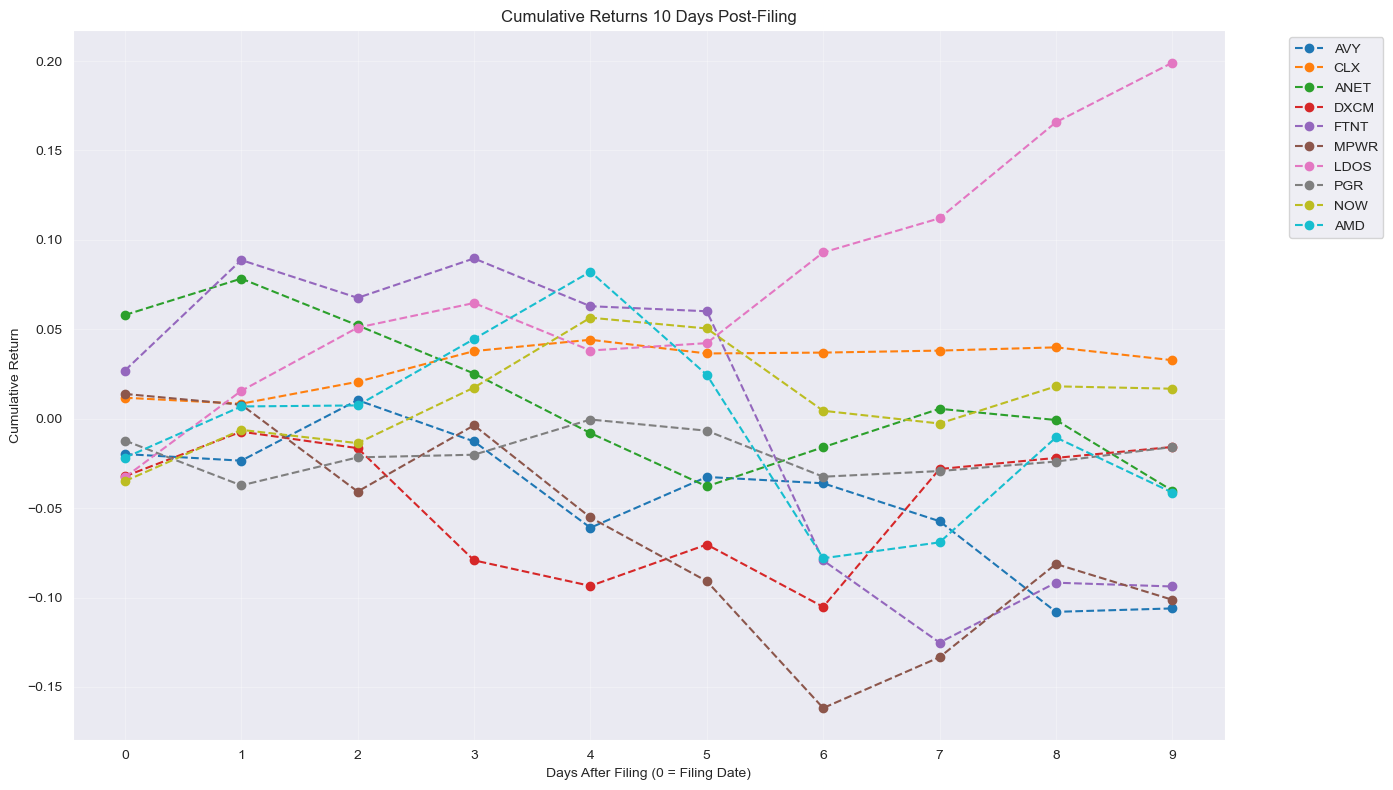

In [43]:
plot_post_filing_returns(top_deviators, returns_df)

* There appears to be a wider spread throughout the interval, indicative of more volatile reactions.

No returns data for CEG
No returns data for FRC
No returns data for SBNY


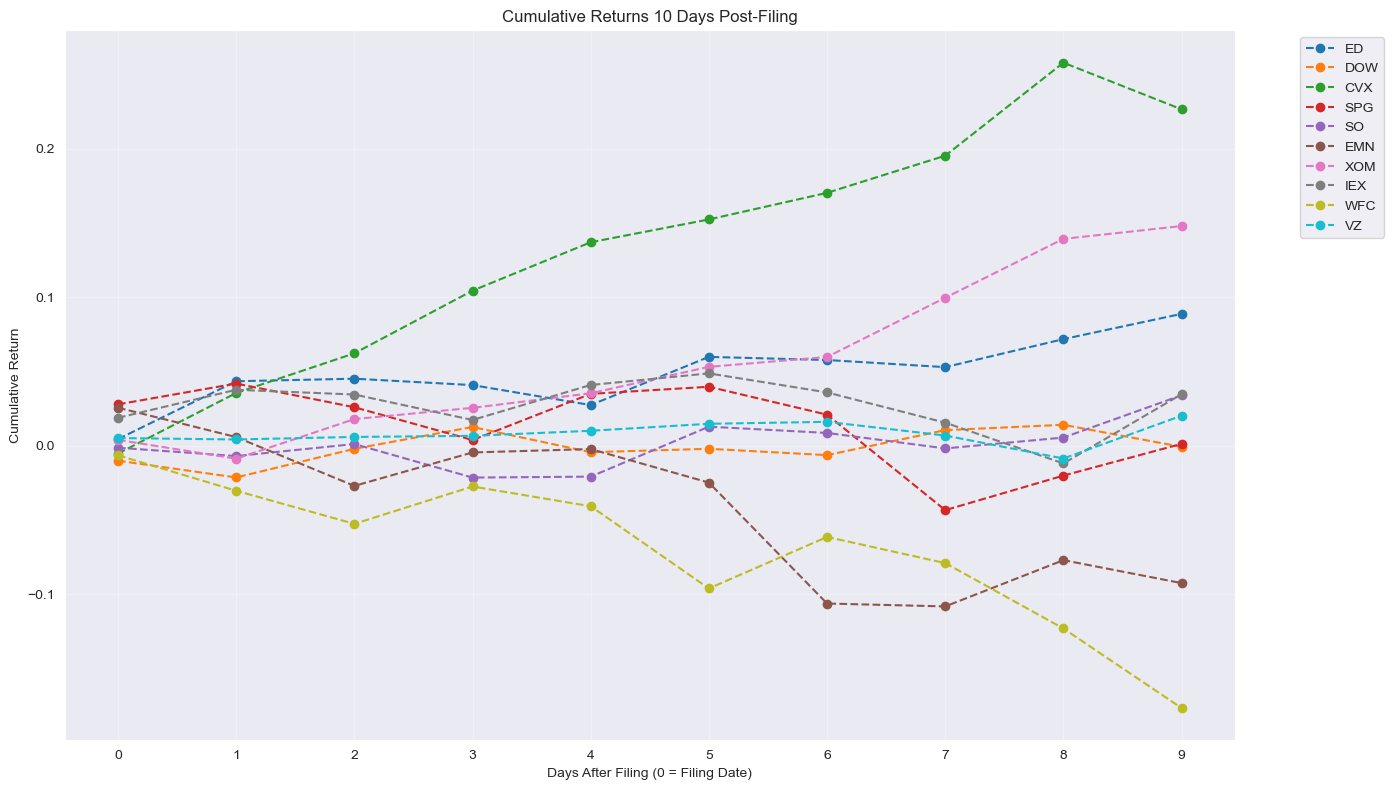

In [44]:
plot_post_filing_returns(min_deviators, returns_df)

* The spread is noticeably tighter in the immediate market reaction with more gradual changes in the lagged raction.

## Overall Findings

## Sector-Specific Sentiment Patterns
- **Variation by Industry:**  
  The strength and direction of correlations between sentiment variables vary markedly by industry. For instance, while the financials sector exhibits strong correlations in litigation-related language, the Industrials sector is characterized by pronounced operational language effects.
- **Implications:**  
  These differences indicate that language emphasis and market interpretation differ substantially across industries.

## Interrelated Sentiment Measures
- **Strong Correlations Within Sectors:**  
  Variables associated with intensifiers, negators, and litigious language tend to correlate strongly with one another within specific sectors.
- **Context-Dependent Effects:**  
  Although these variables show inter-correlation, the magnitude and even the sign of these relationships can vary, emphasizing the contextual importance of industry-specific linguistic norms.

## Immediate vs. Lagged Market Reactions
- **Short-Term vs. Medium-Term Returns:**  
  The study differentiates between short-term (0–2 day) and medium-term (3–10 day) return responses:
  - **Immediate Returns:** Reflect rapid, potentially over-reactive market responses to filings.
  - **Lagged Returns:** Suggest a more gradual adjustment as the market absorbs the reported sentiments and legal uncertainties.
  
## Impact of Litigation and Uncertainty
- **Litigation-Related Volatility:**  
  A pronounced relationship exists between litigation-related language and post-filing volatility.
- **Market Interpretation:**  
  Companies with higher scores in litigious uncertainty tend to experience a wider spread in post-filing returns, indicating that ambiguous legal language is seen as a potential risk indicator.

## Price Movement Trends Around Filing Dates
- **Filing Date Clustering:**  
  Many filings occur around February–March, a period associated with tighter price movements immediately post-filing.
- **Subsequent Adjustments:**  
  After the initial reaction, the market tends to adjust more gradually, suggesting that initial over-reactions are moderated over time.

---
